In [2]:
import numpy as np
import cupy as cp
from cupyx.scipy.signal import convolve2d, correlate2d

def solve_l1_cupy(v, lam):
    """Anisotropic ℓ₁ shrinkage on GPU."""
    return cp.sign(v) * cp.maximum(cp.abs(v) - lam, 0)

def solve_iso_cupy(v_v, v_h, lam):
    """Isotropic ℓ₂ shrinkage on GPU for paired (v_v, v_h)."""
    norms  = cp.sqrt(v_v**2 + v_h**2)
    shrink = cp.maximum(norms - lam, 0) / cp.maximum(norms, 1e-6)
    return v_v * shrink, v_h * shrink

def Dv_cupy(X):
    dv = cp.empty_like(X)
    dv[:-1, :] = X[1:, :] - X[:-1, :]
    dv[-1, :]  = 0
    return dv

def Dh_cupy(X):
    dh = cp.empty_like(X)
    dh[:, :-1] = X[:, 1:] - X[:, :-1]
    dh[:, -1]  = 0
    return dh

def div_cupy(Pv, Ph):
    m, n = Pv.shape
    dv = cp.empty_like(Pv)
    dv[0, :]    = -Pv[0, :]
    dv[1:-1, :] = Pv[:-2, :] - Pv[1:-1, :]
    dv[-1, :]   = Pv[-2, :]
    dh = cp.empty_like(Ph)
    dh[:, 0]    = -Ph[:, 0]
    dh[:, 1:-1] = Ph[:, :-2] - Ph[:, 1:-1]
    dh[:, -1]   = Ph[:, -2]
    return dv + dh

def tv_gapg_cupy(A, b_img, lam,
                 tv_type='aniso',
                 good_entries=None,
                 max_iter=100):
    """
    GPU‐accelerated TV‐GAPG solver with optional mask.

    A            : cupy.ndarray, 2D convolution kernel
    b_img        : cupy.ndarray, shape (m,n), observed image
    lam          : float, regularization weight
    tv_type      : 'aniso' or 'iso'
    good_entries : None or array-like (m,n) mask of 0/1 weights
    max_iter     : int, maximum iterations
    tol          : float, stop tolerance
    """
    m, n = b_img.shape
    corr = correlate2d

    # prepare mask
    if good_entries is None:
        mask = cp.ones_like(b_img)
    else:
        mask = cp.asarray(good_entries)

    # choose shrink
    if tv_type == 'aniso':
        shrink_fn = solve_l1_cupy
    elif tv_type == 'iso':
        shrink_fn = solve_iso_cupy
    else:
        raise ValueError("tv_type must be 'aniso' or 'iso'")

    # initialization
    mu      = cp.linalg.norm(b_img)
    mu_min  = 1e-3 * mu
    A2_est  = cp.minimum(cp.sqrt(cp.count_nonzero(A)*cp.sum(A*A)),
                         cp.sum(cp.abs(A)))
    eta     = 1.0
    rho     = (cp.sqrt(mu)*A2_est + 4*cp.sqrt(eta))**2
    
    x       = b_img.copy()
    y_x     = x.copy()
    u_v     = Dv_cupy(x)
    u_h     = Dh_cupy(x)
    y_u_v   = u_v.copy()
    y_u_h   = u_h.copy()
    t       = cp.array(1.0, dtype=x.dtype)

    # precompute Aᵀb
    At_b    = corr(b_img, A, mode='same', boundary='symm')

    tol_rel  = 1e-4
    tol_obj  = 1e-4
    obj_old  = np.inf
    
    for k in range(max_iter):
        x_prev   = x
        u_v_prev = u_v
        u_h_prev = u_h
        t_prev   = t

        # AᵀA yₓ
        Ax = convolve2d(y_x, A, mode='same', boundary='symm')

        # 2) masked residual
        residual = (Ax - b_img) * good_entries

        # 3) gradient = A^T(masked residual)
        grad_data = correlate2d(residual, A, mode='same', boundary='symm')

        # TV gradient
        y_xC_v  = Dv_cupy(y_x)
        y_xC_h  = Dh_cupy(y_x)
        grad_tv = div_cupy(y_xC_v - y_u_v,
                           y_xC_h - y_u_h)

        # primal update
        x = cp.clip(y_x - (grad_data + grad_tv)/rho, 0, 1)

        # dual updates
        v_v = y_u_v - (y_u_v - y_xC_v)/eta
        v_h = y_u_h - (y_u_h - y_xC_h)/eta
        if tv_type == 'aniso':
            u_v = shrink_fn(v_v, (mu*lam)/eta)
            u_h = shrink_fn(v_h, (mu*lam)/eta)
        else:
            u_v, u_h = shrink_fn(v_v, v_h, (mu*lam)/eta)

        # momentum
        t     = (1 + cp.sqrt(1 + 4*t_prev**2)) / 2
        theta = (t_prev - 1) / t
        y_x   = x + theta * (x - x_prev)
        y_u_v = u_v + theta * (u_v - u_v_prev)
        y_u_h = u_h + theta * (u_h - u_h_prev)

        # continuation
        k1  = k + 1
        rat = ((2*k1 - 2)/(2*k1))**0.125
        mu  = cp.maximum(mu*(0.1*rat + 0.9), mu_min)
        rho = (cp.sqrt(mu)*A2_est + 4*cp.sqrt(eta))**2

        data_f   = 0.5 * cp.sum(residual**2)
        tv_f     = lam * (
                  cp.sum(cp.abs(Dv_cupy(x))) +
                  cp.sum(cp.abs(Dh_cupy(x)))
               )

        obj_new = (data_f + tv_f).item()

        if k >= 50:
            delta   = cp.linalg.norm(x - x_prev).item()
            normx   = cp.linalg.norm(x_prev).item()
            if delta/(normx) < tol_rel:
                print(f"Converged (rel‐tol) at iter {k}")
                break
        
            # 6) objective‐change stopping criterion
            if abs(obj_new - obj_old) < tol_obj:
                print(f"Converged (obj‐tol) at iter {k}: ΔJ={obj_new-obj_old:.2e}")
                break

    return x

In [4]:
from skimage.restoration import inpaint_biharmonic

def psf_gaussian(k_size, k_sigma):
    ax = np.linspace(-(k_size // 2), k_size // 2, k_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2)/(2.0*k_sigma**2))
    P = kernel / np.sum(kernel)
    return P

def score_error(observed_image, estimated_image, good_mask):
    e_all = observed_image - estimated_image
    v = e_all[(1-good_mask).astype(bool)]
    return np.mean(v**2)

def score(observed_image, P, clean_image, good_mask):
    X_reblur = sp_convolve2d(clean_image, P, mode='same', boundary='symm')
    return score_error(observed_image, X_reblur, good_mask)

def fit(observed_image, psf, good_mask, lam=0.000001, warm_start=True):

    psf_cp = cp.array(psf)

    if warm_start:
        masked_obs = observed_image * good_mask
        painted = inpaint_biharmonic(masked_obs, 1-good_mask)
        total = good_mask*observed_image + (1-good_mask)*painted
        img_cp = cp.array(total)
    else:
        masked_obs = observed_image * good_mask
        img_cp = cp.array(masked_obs)
    
    good_mask_cp = cp.array(good_mask)
    
    x_denoised = tv_gapg_cupy(psf_cp, img_cp, lam=lam, tv_type='aniso', good_entries=good_mask_cp, max_iter=10_000)

    x_host = cp.asnumpy(x_denoised)

    return x_host

In [58]:
import itertools
import pandas as pd
from skimage import data, color
import numpy as np
from scipy.signal import convolve2d as sp_convolve2d

rng = np.random.default_rng(seed=0)

# MUCH SHARPER SIGMA CURVE AT p=0.5 rather than p=0.8

mask_p = 0.8
kernel_size = 19
kernel_sigma = 2
noise_sigma = 0.01

# Get PSF
P = psf_gaussian(kernel_size, kernel_sigma)

# # Load image
skim = data.astronaut()
X_true = color.rgb2gray(skim).astype(np.float64)

# Make corrupted image
X_conv = sp_convolve2d(X_true, P, mode='same', boundary='symm')
X_obs = X_conv + noise_sigma*rng.standard_normal(X_conv.shape)

# Generate a mask
good_mask = (rng.random(X_obs.shape) < mask_p).astype(np.float64)

lambdas_range = np.logspace(-6.6, -5.2, 10)

param_list = list(itertools.product(lambdas_range))

tasks = [
    (k_lambda)
    for i, (k_lambda) in enumerate(param_list)
]

def worker(args):
    k_lambda = args[0]

    # Get PSF
    k_P = psf_gaussian(kernel_size, kernel_sigma)
    
    # Fit
    restored = fit(X_obs, k_P, good_mask, lam=k_lambda, warm_start=True)

    return {
        "k_lambda": k_lambda,
        "cv_score": score(X_obs, k_P, restored, good_mask),
        "true_score": np.mean((X_true-restored)**2)
    }

results = map(worker, tasks)

records_df = pd.DataFrame(results)

Converged (rel‐tol) at iter 493
Converged (rel‐tol) at iter 479
Converged (rel‐tol) at iter 466
Converged (rel‐tol) at iter 456
Converged (rel‐tol) at iter 451
Converged (rel‐tol) at iter 452
Converged (rel‐tol) at iter 457
Converged (rel‐tol) at iter 466
Converged (rel‐tol) at iter 477
Converged (rel‐tol) at iter 489


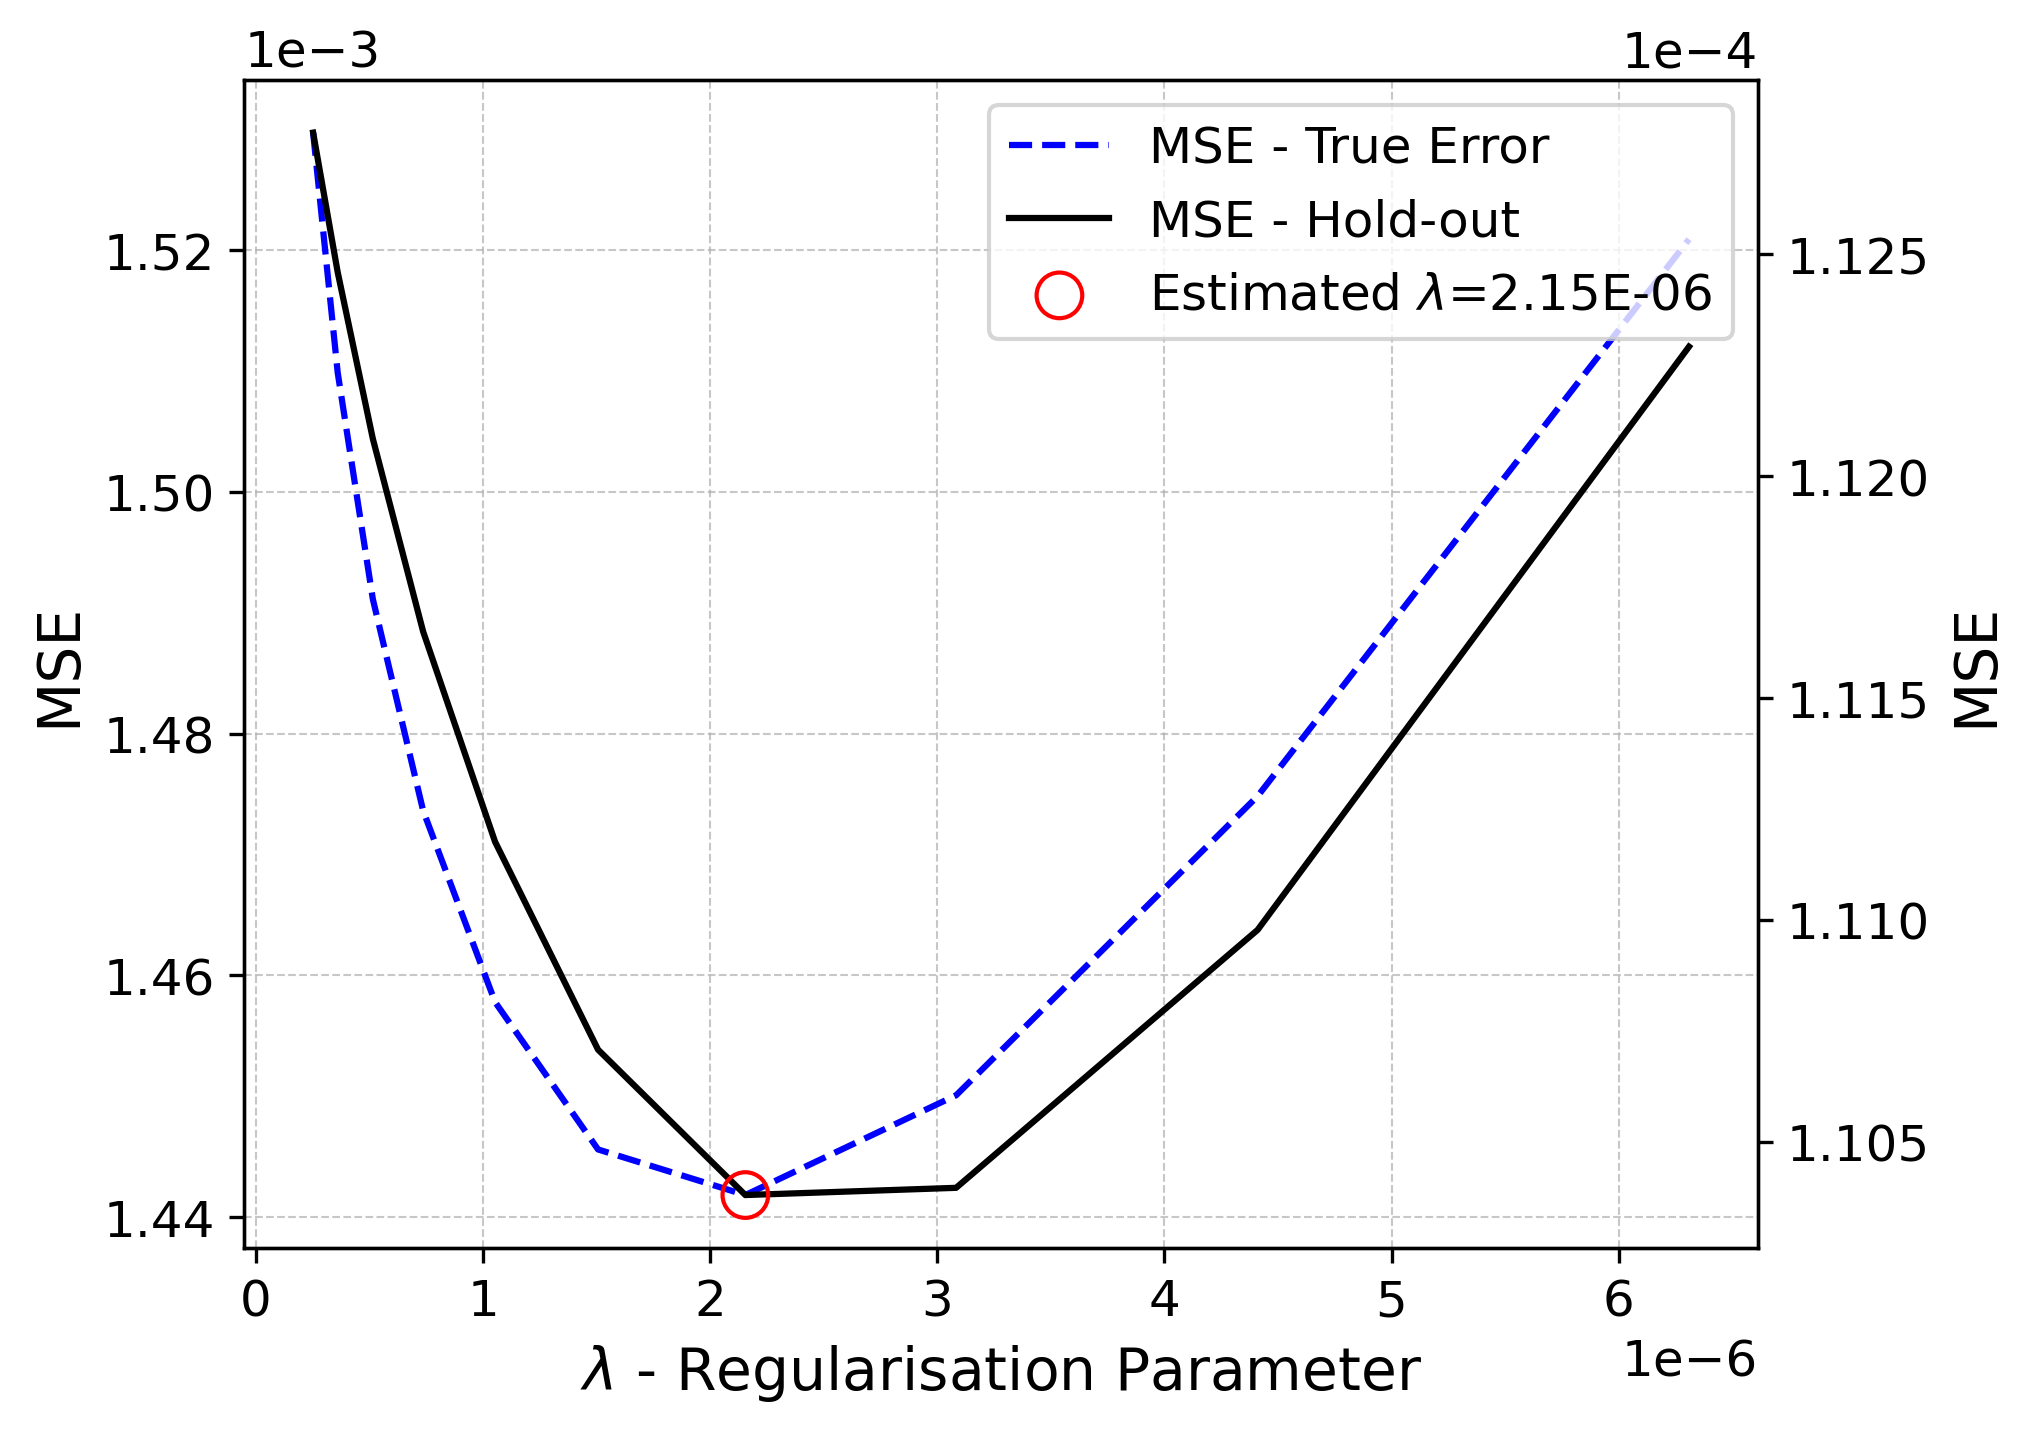

In [59]:
import matplotlib.pyplot as plt
from matplotlib import rc_context

# Estimated optimum
best_cv_idx   = records_df['cv_score'].idxmin()
best_cv_lambda = records_df.loc[best_cv_idx, 'k_lambda']
best_cv_score = records_df.loc[best_cv_idx, 'cv_score']

best_idx   = records_df['true_score'].idxmin()
best_lambda = records_df.loc[best_idx, 'k_lambda']
best_score = records_df.loc[best_idx, 'true_score']

true_sigma = 2.0

# Define your custom rc params
rc_params = {
    'figure.figsize':   (7, 5),
    'figure.dpi':       300,
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'lines.linewidth':  1.5,
    'lines.markersize': 5
}

# Wrap only this figure in the context
with rc_context(rc_params):
    fig, ax = plt.subplots()

    # Plot MSE curve
    ax.plot(records_df['k_lambda'],
            records_df['true_score'],
            linestyle='--', marker='',
            color='blue',
            label='MSE - True Error', zorder=2)

    ax2 = ax.twinx()

    ax2.plot(records_df['k_lambda'],
            records_df['cv_score'],
            linestyle='-', marker='',
            color='black',
            label='MSE - Hold-out', zorder=2)

    # Estimated optimum
    ax2.scatter([best_cv_lambda], [best_cv_score],
            s=120, facecolors='none', edgecolors='r',
            label=f'Estimated $\lambda$={best_lambda:.2E}', zorder=3)
    
    # Decorate
    ax.set_xlabel('$\lambda$ - Regularisation Parameter')
    ax.set_ylabel('MSE')

    ax2.set_ylabel('MSE')
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

    ax.ticklabel_format(axis="both", style='sci', scilimits=(1e1,1e2))
    ax2.ticklabel_format(axis="both", style='sci', scilimits=(1e1,1e2))
    
    plt.tight_layout()

    plt.savefig("poc_lambda_curve.pdf")
    
    plt.show()

In [60]:
import itertools
import pandas as pd
from skimage import data, color
import numpy as np
from scipy.signal import convolve2d as sp_convolve2d

est_kernel_sigma_range = np.arange(1, 3+0.25, 0.25)

param_list = list(itertools.product(est_kernel_sigma_range))

tasks = [
    (k_sigma)
    for i, (k_sigma) in enumerate(param_list)
]

def worker(args):
    k_sigma = args[0]

    # Get PSF
    k_P = psf_gaussian(kernel_size, k_sigma)
    
    # Fit
    restored = fit(X_obs, k_P, good_mask, lam=0.00000215443469003188223619810714, warm_start=False)
    
    return {
        "k_sigma": k_sigma,
        "cv_score": score(X_obs, k_P, restored, good_mask),
        "true_score": np.mean((X_true-restored)**2)
    }

results = map(worker, tasks)

records_df = pd.DataFrame(results)

Converged (rel‐tol) at iter 2223
Converged (rel‐tol) at iter 2384
Converged (rel‐tol) at iter 2516
Converged (rel‐tol) at iter 2607
Converged (rel‐tol) at iter 2671
Converged (rel‐tol) at iter 2729
Converged (rel‐tol) at iter 2773
Converged (rel‐tol) at iter 2807
Converged (rel‐tol) at iter 2827


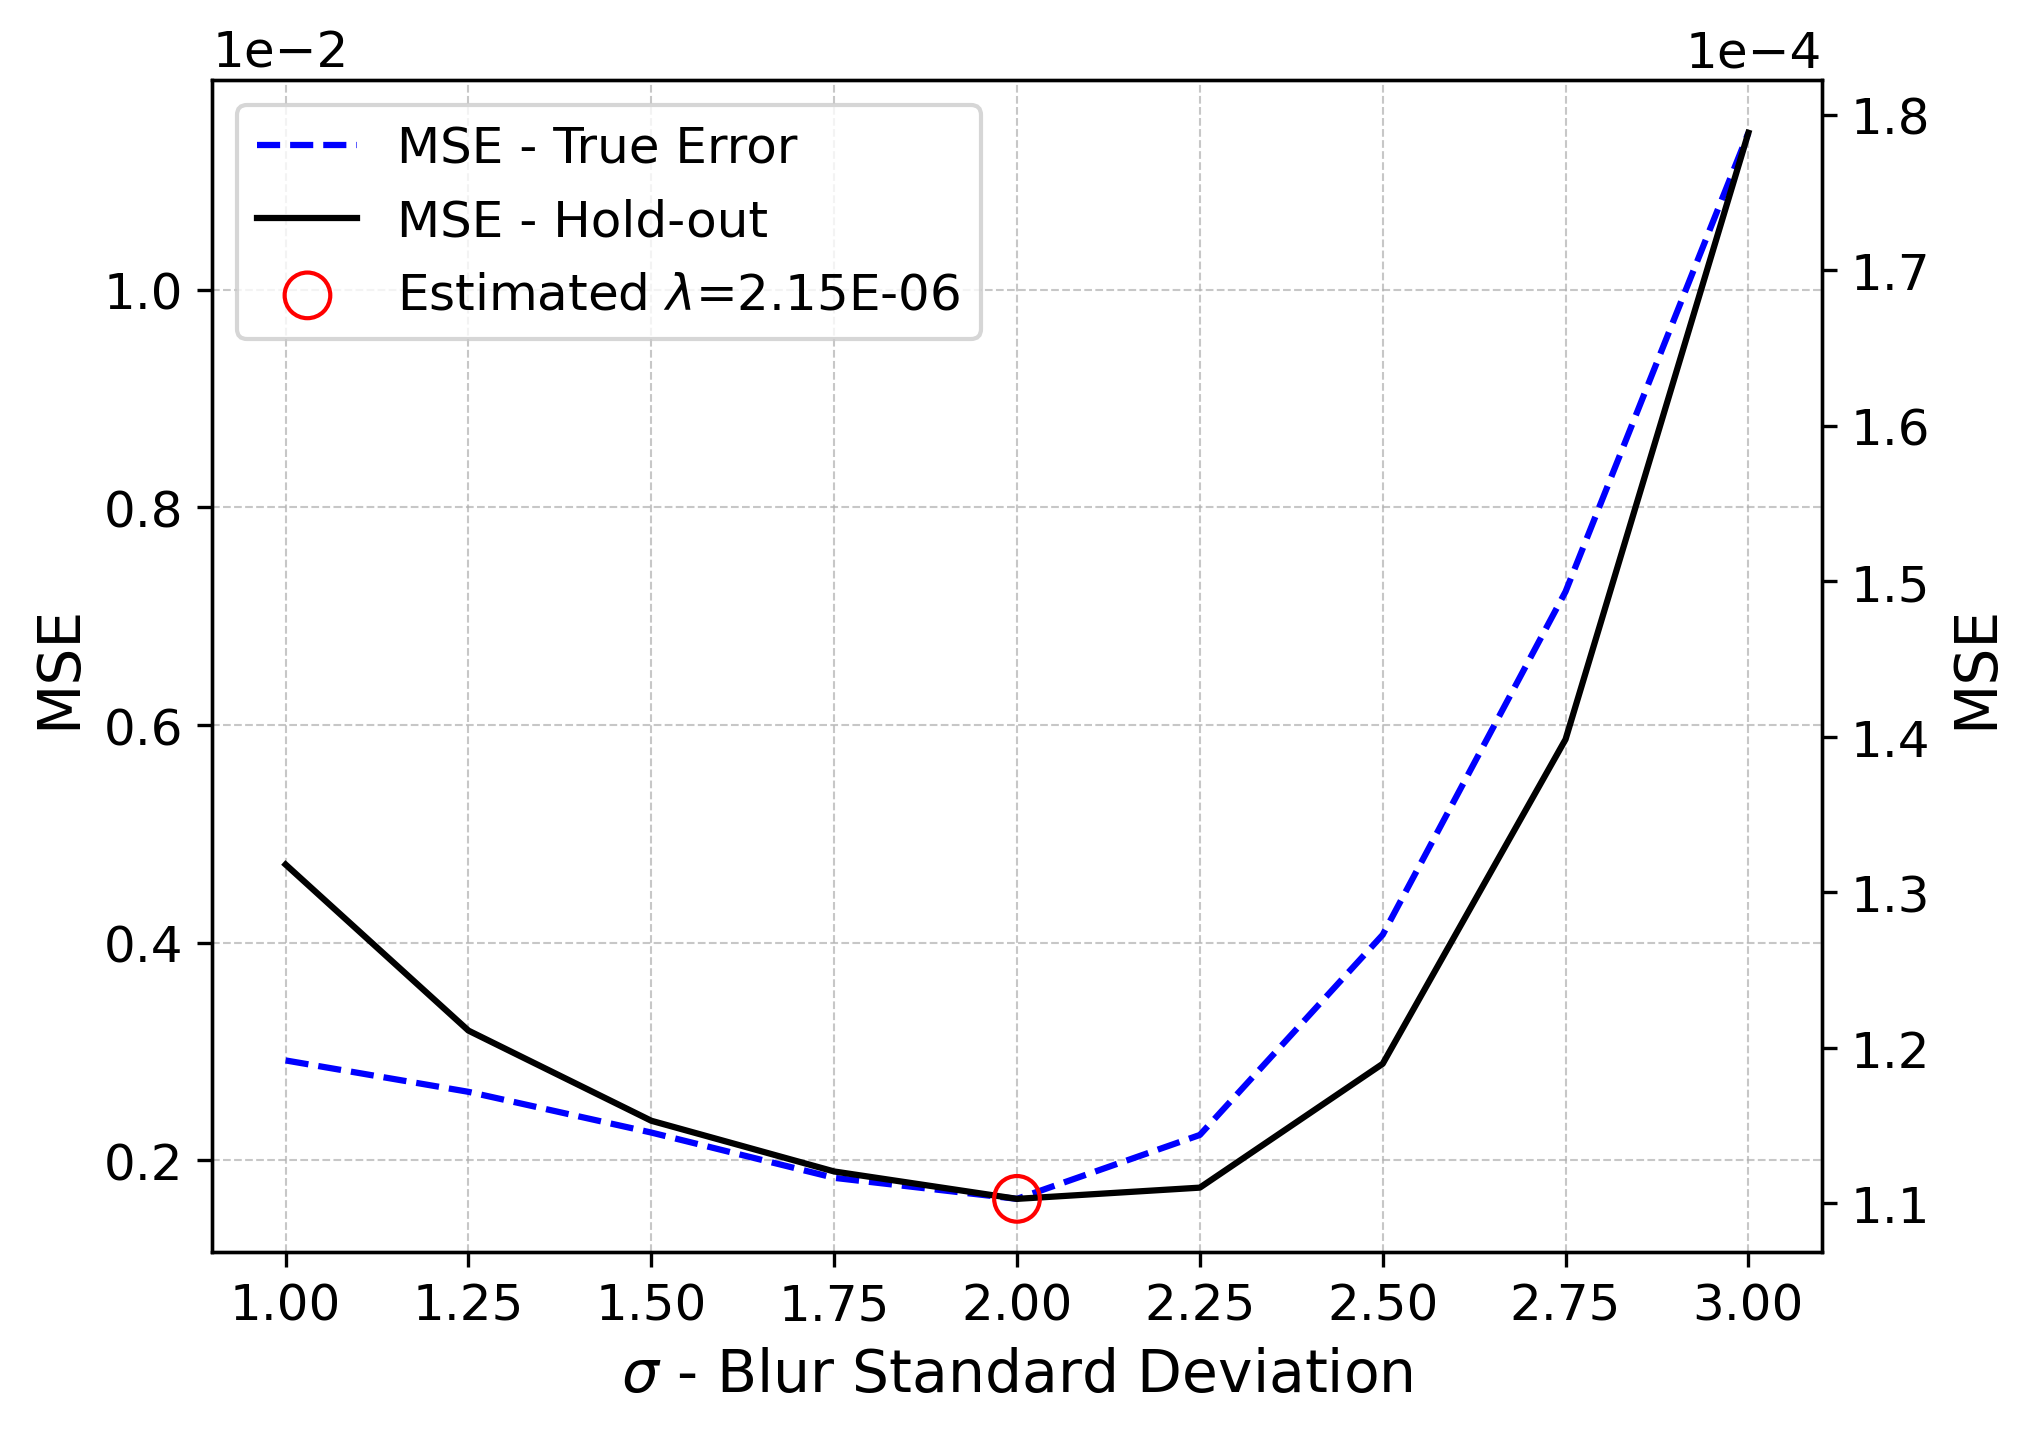

In [63]:
import matplotlib.pyplot as plt
from matplotlib import rc_context

# Estimated optimum
best_cv_idx   = records_df['cv_score'].idxmin()
best_cv_sigma = records_df.loc[best_cv_idx, 'k_sigma']
best_cv_score = records_df.loc[best_cv_idx, 'cv_score']

best_idx   = records_df['true_score'].idxmin()
best_sigma = records_df.loc[best_idx, 'k_sigma']
best_score = records_df.loc[best_idx, 'true_score']

true_sigma = 2.0

# Define your custom rc params
rc_params = {
    'figure.figsize':   (7, 5),
    'figure.dpi':       300,
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'lines.linewidth':  1.5,
    'lines.markersize': 5
}

# Wrap only this figure in the context
with rc_context(rc_params):
    fig, ax = plt.subplots()

    # Plot MSE curve
    ax.plot(records_df['k_sigma'],
            records_df['true_score'],
            linestyle='--', marker='',
            color='blue',
            label='MSE - True Error', zorder=2)

    ax2 = ax.twinx()

    ax2.plot(records_df['k_sigma'],
            records_df['cv_score'],
            linestyle='-', marker='',
            color='black',
            label='MSE - Hold-out', zorder=2)

    # Estimated optimum
    ax2.scatter([best_cv_sigma], [best_cv_score],
            s=120, facecolors='none', edgecolors='r',
            label=f'Estimated $\lambda$={best_lambda:.2E}', zorder=3)
    
    # Decorate
    ax.set_xlabel('$\sigma$ - Blur Standard Deviation')
    ax.set_ylabel('MSE')

    ax2.set_ylabel('MSE')
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

    ax.ticklabel_format(axis="both", style='sci', scilimits=(1e1,1e2))
    ax2.ticklabel_format(axis="both", style='sci', scilimits=(1e1,1e2))
    
    plt.tight_layout()

    plt.savefig("poc_sigma_curve.pdf")
    
    plt.show()

In [57]:
from skimage import io

def fix_image(im):
    # image = np.clip(im, 0, 1)  # if float in [0, 1]
    image = (im - np.min(im))/np.ptp(im)
    image_uint8 = (image * 255).astype(np.uint8)
    return image_uint8

restored = fit(X_obs, P, good_mask, lam=0.00000215443469003188223619810714)

X_reblur = sp_convolve2d(restored, P, mode='same', boundary='symm')

io.imsave("poc_true.png", fix_image(X_true))
io.imsave("poc_obs.png", fix_image(X_obs))
io.imsave("poc_reblur_error.png", fix_image(X_obs - X_reblur))
io.imsave("poc_restored.png", fix_image(restored))

# fig, axs = plt.subplots(1,4, figsize=(32,12))

# axs[0].imshow(obs, cmap='gray')
# axs[1].imshow(X_reblur, cmap='gray')
# axs[2].imshow(obs - X_reblur, cmap='gray')
# axs[3].imshow(x_host, cmap='gray')

Converged (rel‐tol) at iter 464
